In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def process_user_data(mouse_file, pupil_file):
    # Load files
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps to numeric timecodes
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Merge data
    def merge_on_time_intervals(click_data, pupil_data, time_window=5):
        merged_data = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']
            is_promotional = click_row['Is Promotional']

            # Select pupil data in the time window around the click
            relevant_pupil_data = pupil_data[
                (pupil_data['timecode'] >= click_time - time_window) &
                (pupil_data['timecode'] <= click_time + time_window)
            ]
            avg_pupil_area = relevant_pupil_data['pupil-area'].mean()

            merged_data.append({
                'Is Promotional': is_promotional,
                'Click Timecode': click_time,
                'Average Pupil Area': avg_pupil_area
            })

        return pd.DataFrame(merged_data)

    merged_data = merge_on_time_intervals(click_data, pupil_data)

    # Pre- and post-click analysis for promotional clicks
    def calculate_pre_post_pupil_areas(promotional_clicks, pupil_data):
        results = []
        for _, click_row in promotional_clicks.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click window
            pre_click_pupil_area = pupil_data[
                (pupil_data['timecode'] >= click_time - 5) &
                (pupil_data['timecode'] < click_time)
            ]['pupil-area'].mean()

            # Post-click window
            post_click_pupil_area = pupil_data[
                (pupil_data['timecode'] >= click_time + 2) &
                (pupil_data['timecode'] < click_time + 5)
            ]['pupil-area'].mean()

            results.append({
                'Pre-Click Avg Pupil Area': pre_click_pupil_area,
                'Post-Click Avg Pupil Area': post_click_pupil_area
            })

        return pd.DataFrame(results)

    promotional_clicks = click_data[click_data['Is Promotional'] == True]
    pre_post_analysis = calculate_pre_post_pupil_areas(promotional_clicks, pupil_data)

    return merged_data, pre_post_analysis

def analyze_multiple_users(file_pairs):
    all_merged_data = []
    all_pre_post_analysis = []

    for mouse_file, pupil_file in file_pairs:
        merged_data, pre_post_analysis = process_user_data(mouse_file, pupil_file)

        # Append user data
        all_merged_data.append(merged_data)
        all_pre_post_analysis.append(pre_post_analysis)

    # Combine all data into single DataFrames
    combined_merged_data = pd.concat(all_merged_data, ignore_index=True)
    combined_pre_post_analysis = pd.concat(all_pre_post_analysis, ignore_index=True)

    return combined_merged_data, combined_pre_post_analysis

# Example usage
file_pairs = [
    ('anushka3.csv', 'anuksha_v3.csv'),
    ('aryaman3.csv', 'aryamann_v3.csv'),
    ('tanya3.csv', 'tanya_v3.csv'),
    ('trusha3.csv', 'trusha_v3.csv'),
    ('rhea3.csv', 'rhea_v3.csv'),
    ('jain3.csv', 'jain_v3.csv'),
    ('priyansh3.csv', 'priyansh_v3.csv'),
    ('priyanshu3.csv', 'priyanshu_v3.csv'),
    ('sani3.csv', 'sanidhya_v3.csv'),
    ('suhani3.csv','suhani_v3.csv'),
    ('surabhi3.csv', 'surabhi_v3.csv'),
    ('vaish3.csv', 'vaish_v3.csv')
    
]

# Analyze all users
combined_merged_data, combined_pre_post_analysis = analyze_multiple_users(file_pairs)

print("Overall Summary:")
print(combined_merged_data.groupby('Is Promotional')['Average Pupil Area'].describe())
print("Pre and Post-Click Pupil Area Comparison:")
print(combined_pre_post_analysis.describe())


In [ ]:
# Plot visualizations based on the combined analysis
plt.figure(dpi=120, figsize=(20, 6))
plt.boxplot(
    [combined_pre_post_analysis['Pre-Click Avg Pupil Area'].dropna(),
     combined_pre_post_analysis['Post-Click Avg Pupil Area'].dropna()],
    labels=['Pre-Click', 'Post-Click']
)
plt.title("Pupil Area Before and After Promotional Clicks")
plt.ylabel("Pupil Area")
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Generate tables for the overall summary and pre-post analysis

from tabulate import tabulate

# Table 1: Overall Summary of Average Pupil Area for Promotional vs Non-Promotional
overall_summary = combined_merged_data.groupby('Is Promotional')['Average Pupil Area'].describe()

# Table 2: Summary statistics for Pre- and Post-Click Pupil Areas
pre_post_summary = combined_pre_post_analysis.describe()

# Print tables in a clean format
print("### Overall Summary of Average Pupil Area (Promotional vs Non-Promotional) ###")
print(tabulate(overall_summary, headers='keys', tablefmt='grid'))

print("\n### Pre- and Post-Click Pupil Area Comparison ###")
print(tabulate(pre_post_summary, headers='keys', tablefmt='grid'))


## Normalized

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def process_user_data(mouse_file, pupil_file):
    # Load files
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps to numeric timecodes
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with the mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Correct Min-Max Normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Merge data
    def merge_on_time_intervals(click_data, pupil_data, time_window=5):
        merged_data = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']
            is_promotional = click_row['Is Promotional']

            # Select pupil data in the time window around the click
            relevant_pupil_data = pupil_data[
                (pupil_data['timecode'] >= click_time - time_window) &
                (pupil_data['timecode'] <= click_time + time_window)
            ]
            avg_pupil_area = relevant_pupil_data['normalized-pupil-area'].mean()

            merged_data.append({
                'Is Promotional': is_promotional,
                'Click Timecode': click_time,
                'Normalized Average Pupil Area': avg_pupil_area
            })

        return pd.DataFrame(merged_data)

    merged_data = merge_on_time_intervals(click_data, pupil_data)

    # Pre- and post-click analysis for promotional clicks
    def calculate_pre_post_pupil_areas(promotional_clicks, pupil_data):
        results = []
        for _, click_row in promotional_clicks.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click window
            pre_click_pupil_area = pupil_data[
                (pupil_data['timecode'] >= click_time - 5) & 
                (pupil_data['timecode'] < click_time)
            ]['normalized-pupil-area'].mean()

            # Post-click window
            post_click_pupil_area = pupil_data[
                (pupil_data['timecode'] >= click_time + 2) & 
                (pupil_data['timecode'] < click_time + 5)
            ]['normalized-pupil-area'].mean()

            results.append({
                'Pre-Click Avg Pupil Area': pre_click_pupil_area,
                'Post-Click Avg Pupil Area': post_click_pupil_area
            })

        return pd.DataFrame(results)

    promotional_clicks = click_data[click_data['Is Promotional'] == True]
    pre_post_analysis = calculate_pre_post_pupil_areas(promotional_clicks, pupil_data)

    return merged_data, pre_post_analysis

def analyze_multiple_users(file_pairs):
    all_merged_data = []
    all_pre_post_analysis = []

    for mouse_file, pupil_file in file_pairs:
        merged_data, pre_post_analysis = process_user_data(mouse_file, pupil_file)

        # Append user data
        all_merged_data.append(merged_data)
        all_pre_post_analysis.append(pre_post_analysis)

    # Combine all data into single DataFrames
    combined_merged_data = pd.concat(all_merged_data, ignore_index=True)
    combined_pre_post_analysis = pd.concat(all_pre_post_analysis, ignore_index=True)

    return combined_merged_data, combined_pre_post_analysis

# Example usage
file_pairs = [
    ('anushka3.csv', 'anuksha_v3.csv'),
    ('aryaman3.csv', 'aryamann_v3.csv'),
    ('tanya3.csv', 'tanya_v3.csv'),
    ('trusha3.csv', 'trusha_v3.csv'),
    ('rhea3.csv', 'rhea_v3.csv'),
    ('jain3.csv', 'jain_v3.csv'),
    ('priyansh3.csv', 'priyansh_v3.csv'),
    ('priyanshu3.csv', 'priyanshu_v3.csv'),
    ('sani3.csv', 'sanidhya_v3.csv'),
    ('suhani3.csv', 'suhani_v3.csv'),
    ('surabhi3.csv', 'surabhi_v3.csv'),
    ('vaish3.csv', 'vaish_v3.csv')
]

# Analyze all users
combined_merged_data, combined_pre_post_analysis = analyze_multiple_users(file_pairs)

# # Print normalized summary
# print("### Overall Summary (Normalized) ###")
# print(combined_merged_data.groupby('Is Promotional')['Normalized Average Pupil Area'].describe())

print("\n### Pre and Post-Click Normalized Pupil Area Comparison ###")
print(combined_pre_post_analysis.describe())



### Pre and Post-Click Normalized Pupil Area Comparison ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 41.000000                  41.000000
mean                   0.405476                   0.438845
std                    0.179416                   0.186157
min                    0.140511                   0.139064
25%                    0.248466                   0.287437
50%                    0.395373                   0.461737
75%                    0.578672                   0.592033
max                    0.701950                   0.742518


# Single User

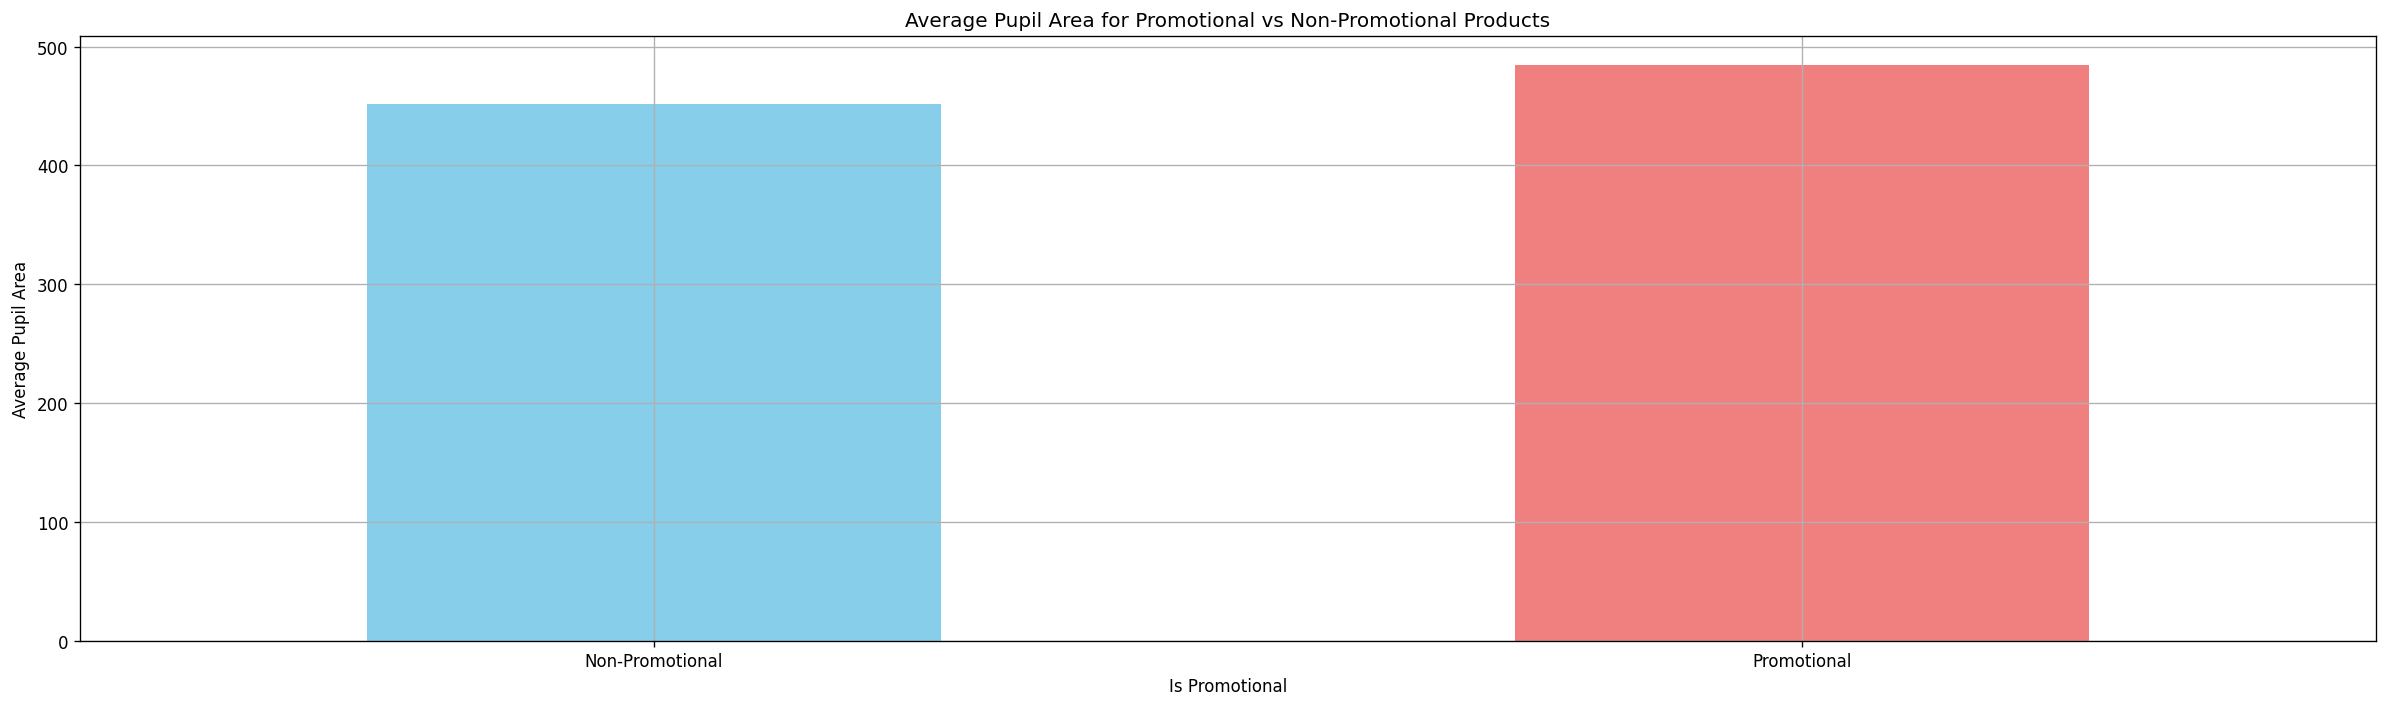

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
click_data = pd.read_csv('vaish3.csv')
pupil_data = pd.read_csv('vaish_v3.csv')

# Convert timestamps to timecodes for both datasets
click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

# Function to merge on time intervals
def merge_on_time_intervals(click_data, pupil_data, time_window=5):
    merged_data = []

    # Iterate through each click data row
    for _, click_row in click_data.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_is_promotional = click_row['Is Promotional']
        
        # Find the range of pupil data around the click time (± time_window seconds)
        time_range_start = click_time - time_window
        time_range_end = click_time + time_window

        # Select the relevant pupil data in this time window
        relevant_pupil_data = pupil_data[(pupil_data['timecode'] >= time_range_start) & (pupil_data['timecode'] <= time_range_end)]
        
        # Calculate the average pupil area for the selected time range
        avg_pupil_area = relevant_pupil_data['pupil-area'].mean()

        # Store merged data with additional info
        merged_data.append({
            'Product Name': click_row['Product Name'],
            'Is Promotional': product_is_promotional,
            'Click Timecode': click_time,
            'Average Pupil Area': avg_pupil_area
        })

    return pd.DataFrame(merged_data)

# Merge the datasets
merged_data = merge_on_time_intervals(click_data, pupil_data, time_window=5)

# Group by 'Is Promotional' and calculate the mean pupil area
pupil_area_comparison = merged_data.groupby('Is Promotional')['Average Pupil Area'].mean()

# Plot the comparison
plt.figure(figsize=(20, 6), dpi=120)
pupil_area_comparison.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Average Pupil Area for Promotional vs Non-Promotional Products')
plt.xlabel('Is Promotional')
plt.ylabel('Average Pupil Area')
plt.xticks([0, 1], ['Non-Promotional', 'Promotional'], rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter clicks for promotional items only
promotional_clicks = click_data[click_data['Is Promotional'] == True]

# Define the function to calculate pre- and post-click averages
def calculate_pre_post_pupil_areas(promotional_clicks, pupil_data):
    results = []

    for _, click_row in promotional_clicks.iterrows():
        click_time = click_row['Timecode (seconds)']
        product_name = click_row['Product Name']

        # Pre-click window: 5 seconds before the click
        pre_click_start = click_time - 5
        pre_click_end = click_time
        pre_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= pre_click_start) & (pupil_data['timecode'] < pre_click_end)
        ]['pupil-area'].mean()

        # Post-click window: 3 seconds starting 2 seconds after the click
        post_click_start = click_time + 2
        post_click_end = click_time + 5
        post_click_pupil_area = pupil_data[
            (pupil_data['timecode'] >= post_click_start) & (pupil_data['timecode'] < post_click_end)
        ]['pupil-area'].mean()

        # Append the results
        results.append({
            'Product Name': product_name,
            'Click Timecode': click_time,
            'Pre-Click Avg Pupil Area': pre_click_pupil_area,
            'Post-Click Avg Pupil Area': post_click_pupil_area
        })

    return pd.DataFrame(results)

# Calculate the pre- and post-click pupil areas
pre_post_pupil_areas = calculate_pre_post_pupil_areas(promotional_clicks, pupil_data)


# V2 vs V3

Processing V2: anushka2.csv and anuksha_v2.csv...
Processing V2: aryaman2.csv and aryamann_v2.csv...
Processing V2: jain2.csv and jain_v2.csv...
Processing V2: priyanshu2.csv and priyanshu_v2.csv...
Processing V2: rhea2.csv and rhea_v2.csv...
Processing V3: anushka3.csv and anuksha_v3.csv...
Processing V3: aryaman3.csv and aryamann_v3.csv...
Processing V3: jain3.csv and jain_v3.csv...
Processing V3: priyanshu3.csv and priyanshu_v3.csv...
Processing V3: rhea3.csv and rhea_v3.csv...

### V2 Pre- and Post-Click Normalized Pupil Area ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 19.000000                  19.000000
mean                   0.325603                   0.315339
std                    0.186955                   0.182083
min                    0.169699                   0.138136
25%                    0.186160                   0.192361
50%                    0.227988                   0.228564
75%                    0.454569                

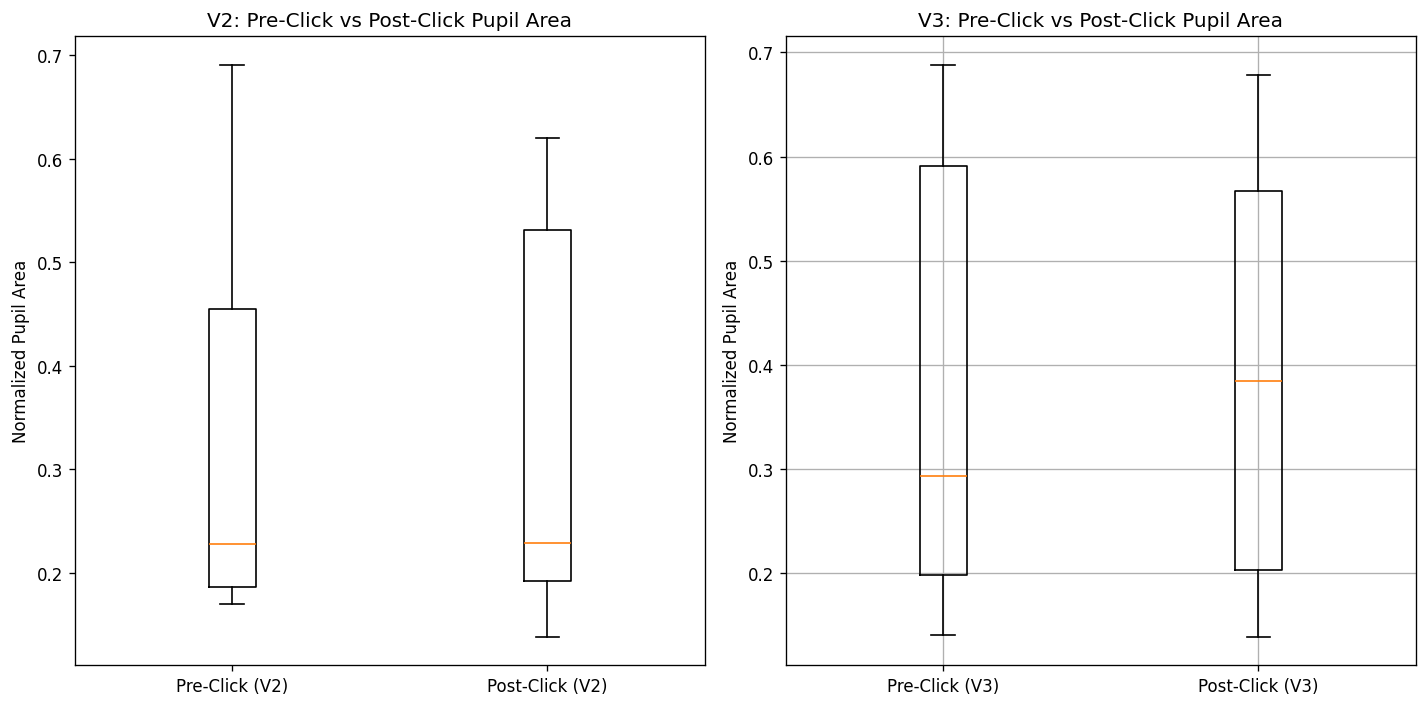

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Function to process user data
def process_user_data(mouse_file, pupil_file):
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps to numeric timecodes
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with the mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Min-Max normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Pre- and post-click analysis
    def calculate_pre_post_pupil_areas(click_data, pupil_data):
        results = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click and post-click windows
            pre_click = pupil_data[(pupil_data['timecode'] >= click_time - 5) & (pupil_data['timecode'] < click_time)]
            post_click = pupil_data[(pupil_data['timecode'] >= click_time + 2) & (pupil_data['timecode'] < click_time + 5)]

            results.append({
                'Pre-Click Avg Pupil Area': pre_click['normalized-pupil-area'].mean(),
                'Post-Click Avg Pupil Area': post_click['normalized-pupil-area'].mean()
            })
        return pd.DataFrame(results)

    return calculate_pre_post_pupil_areas(click_data[click_data['Is Promotional'] == True], pupil_data)

# Compare V2 and V3
def compare_v2_v3(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files):
    all_v2_results = []
    all_v3_results = []

    # Pair files for V2
    for v2_mouse, v2_pupil in zip(v2_mouse_files, v2_pupil_files):
        print(f"Processing V2: {v2_mouse} and {v2_pupil}...")
        v2_results = process_user_data(v2_mouse, v2_pupil)
        all_v2_results.append(v2_results)

    # Pair files for V3
    for v3_mouse, v3_pupil in zip(v3_mouse_files, v3_pupil_files):
        print(f"Processing V3: {v3_mouse} and {v3_pupil}...")
        v3_results = process_user_data(v3_mouse, v3_pupil)
        all_v3_results.append(v3_results)

    # Combine results
    combined_v2 = pd.concat(all_v2_results, ignore_index=True)
    combined_v3 = pd.concat(all_v3_results, ignore_index=True)

    return combined_v2, combined_v3

# File lists for V2 and V3 (mouse and pupil)
v2_mouse_files = ['anushka2.csv', 'aryaman2.csv', 'jain2.csv', 'priyanshu2.csv', 'rhea2.csv']
v2_pupil_files = ['anuksha_v2.csv', 'aryamann_v2.csv', 'jain_v2.csv', 'priyanshu_v2.csv', 'rhea_v2.csv']

v3_mouse_files = ['anushka3.csv', 'aryaman3.csv', 'jain3.csv', 'priyanshu3.csv', 'rhea3.csv']
v3_pupil_files = ['anuksha_v3.csv', 'aryamann_v3.csv', 'jain_v3.csv', 'priyanshu_v3.csv', 'rhea_v3.csv']

# Compare V2 and V3
combined_v2_results, combined_v3_results = compare_v2_v3(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files)

# Display results
print("\n### V2 Pre- and Post-Click Normalized Pupil Area ###")
print(combined_v2_results.describe())

print("\n### V3 Pre- and Post-Click Normalized Pupil Area ###")
print(combined_v3_results.describe())

# Visualize the difference
plt.figure(figsize=(12, 6), dpi=120)

# Boxplot for V2
plt.subplot(1, 2, 1)
plt.boxplot([combined_v2_results['Pre-Click Avg Pupil Area'].dropna(),
             combined_v2_results['Post-Click Avg Pupil Area'].dropna()],
            labels=['Pre-Click (V2)', 'Post-Click (V2)'])
plt.title("V2: Pre-Click vs Post-Click Pupil Area")
plt.ylabel("Normalized Pupil Area")

# Boxplot for V3
plt.subplot(1, 2, 2)
plt.boxplot([combined_v3_results['Pre-Click Avg Pupil Area'].dropna(),
             combined_v3_results['Post-Click Avg Pupil Area'].dropna()],
            labels=['Pre-Click (V3)', 'Post-Click (V3)'])
plt.title("V3: Pre-Click vs Post-Click Pupil Area")
plt.ylabel("Normalized Pupil Area")

plt.grid(True)

plt.tight_layout()
plt.show()


Processing V2: anushka2.csv and anuksha_v2.csv...
Processing V2: aryaman2.csv and aryamann_v2.csv...
Processing V2: jain2.csv and jain_v2.csv...
Processing V2: priyanshu2.csv and priyanshu_v2.csv...
Processing V2: rhea2.csv and rhea_v2.csv...
Processing V3: anushka3.csv and anuksha_v3.csv...
Processing V3: aryaman3.csv and aryamann_v3.csv...
Processing V3: jain3.csv and jain_v3.csv...
Processing V3: priyanshu3.csv and priyanshu_v3.csv...
Processing V3: rhea3.csv and rhea_v3.csv...

### V2 Summary ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 19.000000                  19.000000
mean                   0.325603                   0.315339
std                    0.186955                   0.182083
min                    0.169699                   0.138136
25%                    0.186160                   0.192361
50%                    0.227988                   0.228564
75%                    0.454569                   0.531283
max                   

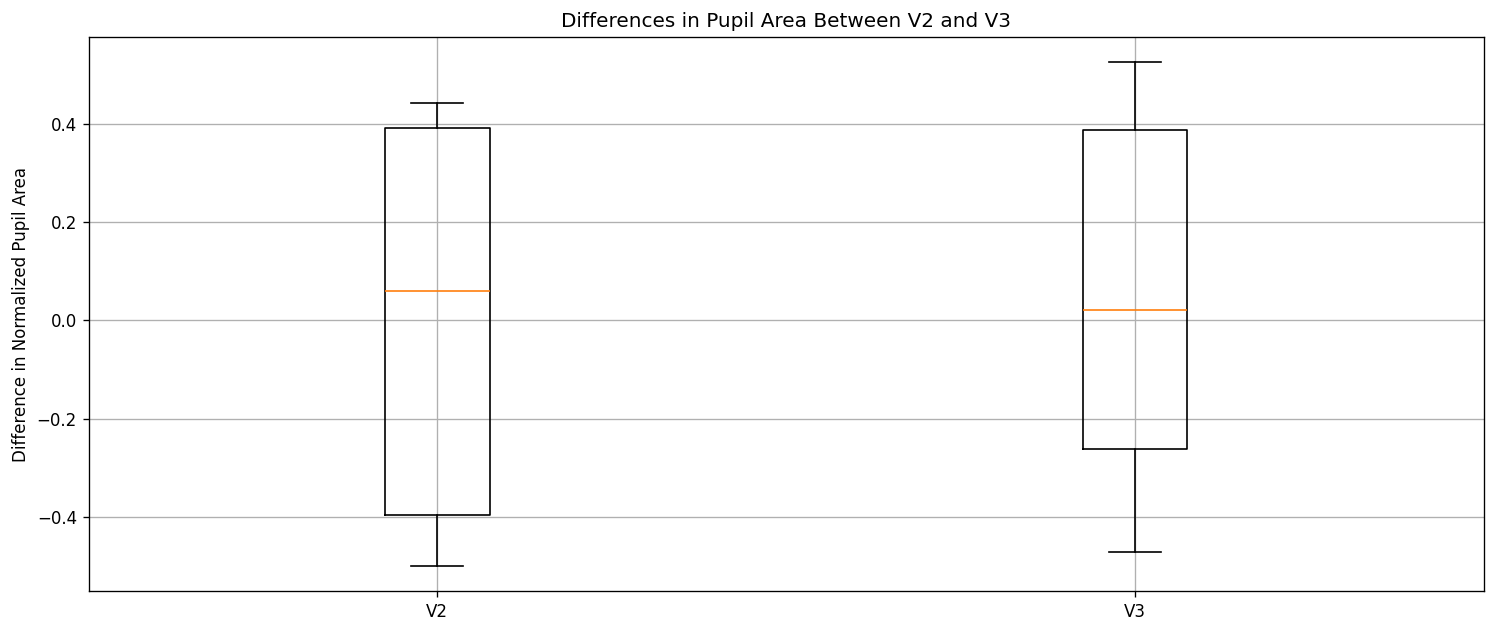

In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Function to process user data
def process_user_data(mouse_file, pupil_file):
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps to numeric timecodes
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with the mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Min-Max normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Pre- and post-click analysis
    def calculate_pre_post_pupil_areas(click_data, pupil_data):
        results = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click and post-click windows
            pre_click = pupil_data[(pupil_data['timecode'] >= click_time - 5) & (pupil_data['timecode'] < click_time)]
            post_click = pupil_data[(pupil_data['timecode'] >= click_time + 2) & (pupil_data['timecode'] < click_time + 5)]

            results.append({
                'Pre-Click Avg Pupil Area': pre_click['normalized-pupil-area'].mean(),
                'Post-Click Avg Pupil Area': post_click['normalized-pupil-area'].mean()
            })
        return pd.DataFrame(results)

    return calculate_pre_post_pupil_areas(click_data[click_data['Is Promotional'] == True], pupil_data)

# Compare V2 and V3
def compare_v2_v3(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files):
    all_v2_results = []
    all_v3_results = []

    # Pair files for V2
    for v2_mouse, v2_pupil in zip(v2_mouse_files, v2_pupil_files):
        print(f"Processing V2: {v2_mouse} and {v2_pupil}...")
        v2_results = process_user_data(v2_mouse, v2_pupil)
        all_v2_results.append(v2_results)

    # Pair files for V3
    for v3_mouse, v3_pupil in zip(v3_mouse_files, v3_pupil_files):
        print(f"Processing V3: {v3_mouse} and {v3_pupil}...")
        v3_results = process_user_data(v3_mouse, v3_pupil)
        all_v3_results.append(v3_results)

    # Combine results
    combined_v2 = pd.concat(all_v2_results, ignore_index=True)
    combined_v3 = pd.concat(all_v3_results, ignore_index=True)

    return combined_v2, combined_v3

# Compare differences between V2 and V3
def compare_differences(combined_v2, combined_v3):
    diff_pre_click = combined_v3['Pre-Click Avg Pupil Area'] - combined_v2['Pre-Click Avg Pupil Area']
    diff_post_click = combined_v3['Post-Click Avg Pupil Area'] - combined_v2['Post-Click Avg Pupil Area']

    # Combine into a single dataframe
    differences = pd.DataFrame({
        'V2': diff_pre_click,
        'V3': diff_post_click
    })

    return differences

# File lists for V2 and V3
v2_mouse_files = ['anushka2.csv', 'aryaman2.csv', 'jain2.csv', 'priyanshu2.csv', 'rhea2.csv']
v2_pupil_files = ['anuksha_v2.csv', 'aryamann_v2.csv', 'jain_v2.csv', 'priyanshu_v2.csv', 'rhea_v2.csv']

v3_mouse_files = ['anushka3.csv', 'aryaman3.csv', 'jain3.csv', 'priyanshu3.csv', 'rhea3.csv']
v3_pupil_files = ['anuksha_v3.csv', 'aryamann_v3.csv', 'jain_v3.csv', 'priyanshu_v3.csv', 'rhea_v3.csv']

# Compare V2 and V3
combined_v2_results, combined_v3_results = compare_v2_v3(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files)

# Calculate differences
differences = compare_differences(combined_v2_results, combined_v3_results)

# Display summary
print("\n### V2 Summary ###")
print(combined_v2_results.describe())

print("\n### V3 Summary ###")
print(combined_v3_results.describe())

print("\n### Differences Between V2 and V3 ###")
print(differences.describe())

# Visualize Differences
plt.figure(figsize=(15, 6), dpi=120)

plt.boxplot([
    differences['V2'].dropna(),
    differences['V3'].dropna()
], labels=['V2', 'V3'])

plt.title("Differences in Pupil Area Between V2 and V3")
plt.ylabel("Difference in Normalized Pupil Area")
plt.grid(True)
plt.show()


# Redone

## v2 vs v3

### V2 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 61.000000                  61.000000
mean                   0.358781                   0.353593
std                    0.169771                   0.176392
min                    0.060802                   0.069922
25%                    0.217601                   0.208844
50%                    0.299697                   0.291274
75%                    0.516516                   0.545308
max                    0.690884                   0.653176


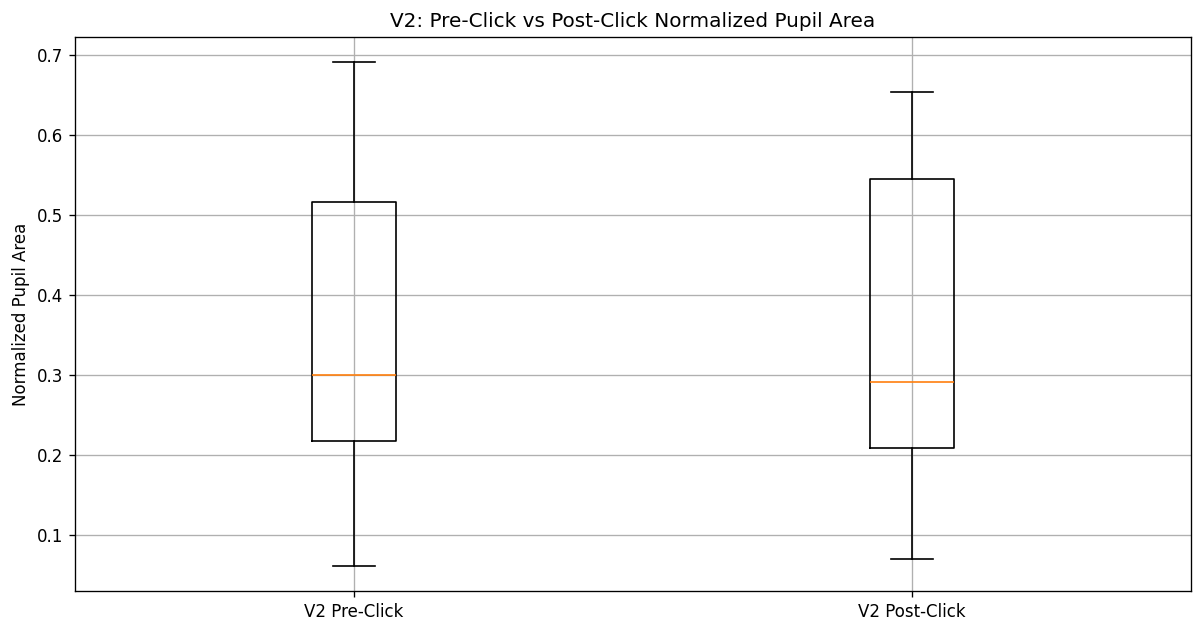

### V3 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 46.000000                  46.000000
mean                   0.426486                   0.445301
std                    0.191085                   0.185765
min                    0.131059                   0.139064
25%                    0.250679                   0.287848
50%                    0.423948                   0.481048
75%                    0.620324                   0.595382
max                    0.701950                   0.742518


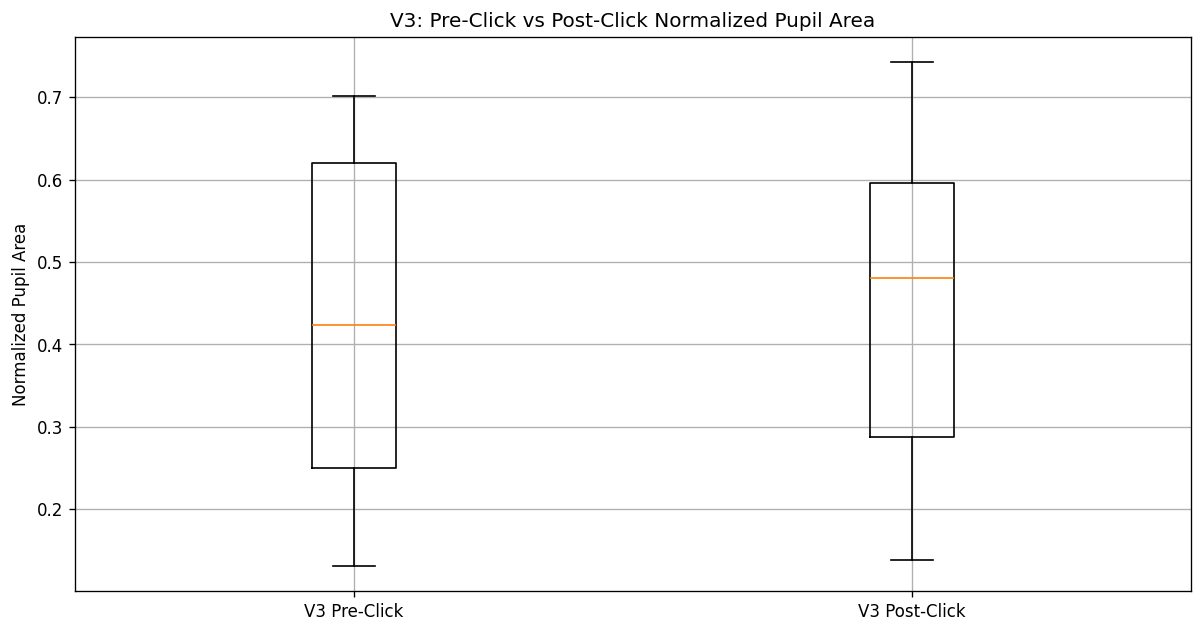

### Post-Click: V2 vs V3 ###
       V2 Post-Click  V3 Post-Click
count      61.000000      46.000000
mean        0.353593       0.445301
std         0.176392       0.185765
min         0.069922       0.139064
25%         0.208844       0.287848
50%         0.291274       0.481048
75%         0.545308       0.595382
max         0.653176       0.742518


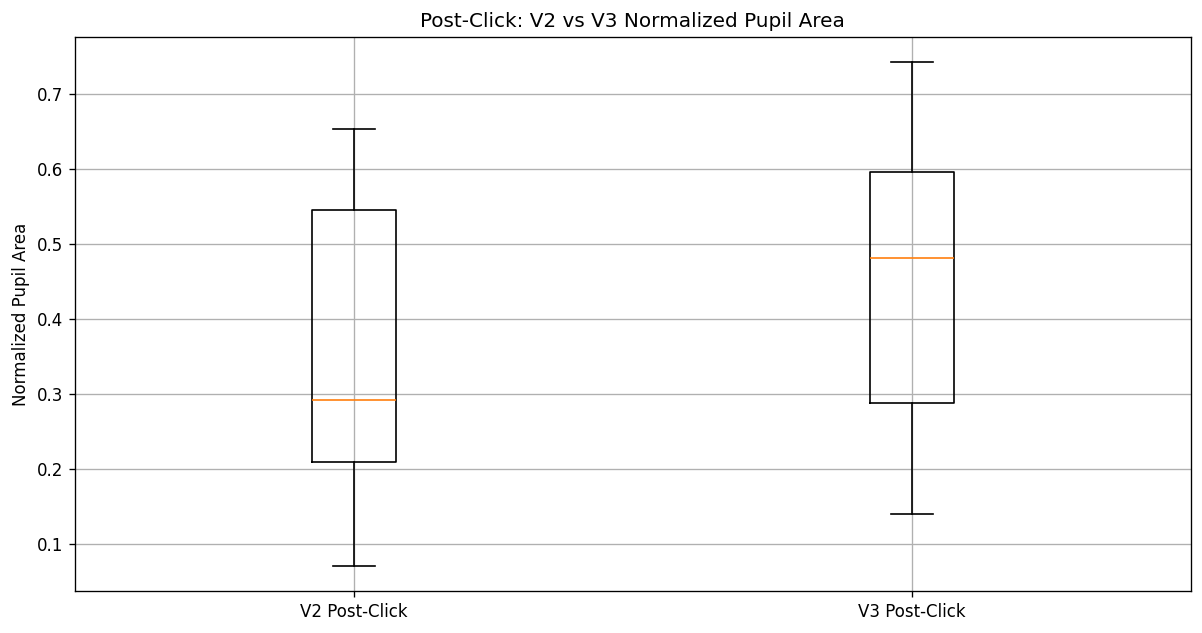

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process user data
def process_user_data(mouse_file, pupil_file):
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Min-Max normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Pre- and post-click analysis
    def calculate_pre_post_pupil_areas(click_data, pupil_data):
        results = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click and post-click windows
            pre_click = pupil_data[(pupil_data['timecode'] >= click_time - 5) & (pupil_data['timecode'] < click_time)]
            post_click = pupil_data[(pupil_data['timecode'] >= click_time + 2) & (pupil_data['timecode'] < click_time + 5)]

            results.append({
                'Pre-Click Avg Pupil Area': pre_click['normalized-pupil-area'].mean(),
                'Post-Click Avg Pupil Area': post_click['normalized-pupil-area'].mean()
            })
        return pd.DataFrame(results)

    return calculate_pre_post_pupil_areas(click_data[click_data['Is Promotional'] == True], pupil_data)

# Compare V2 and V3
def compare_versions(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files):
    all_v2_results = []
    all_v3_results = []

    # Process V2
    for v2_mouse, v2_pupil in zip(v2_mouse_files, v2_pupil_files):
        v2_results = process_user_data(v2_mouse, v2_pupil)
        all_v2_results.append(v2_results)

    # Process V3
    for v3_mouse, v3_pupil in zip(v3_mouse_files, v3_pupil_files):
        v3_results = process_user_data(v3_mouse, v3_pupil)
        all_v3_results.append(v3_results)

    # Combine results
    combined_v2 = pd.concat(all_v2_results, ignore_index=True)
    combined_v3 = pd.concat(all_v3_results, ignore_index=True)

    return combined_v2, combined_v3

# File lists for V2 and V3
v2_mouse_files = ['anushka2.csv', 'aryaman2.csv', 'jain2.csv', 'priyanshu2.csv', 'rhea2.csv', 'amog2.csv','priyansh2.csv','priyanshu2.csv','sani2.csv','suhani2.csv','surabhi2.csv','tanya2.csv','trusha2.csv','vaish2.csv']
v2_pupil_files = ['anuksha_v2.csv', 'aryamann_v2.csv', 'jain_v2.csv', 'priyanshu_v2.csv', 'rhea_v2.csv', 'amog_v2.csv', 'priyansh_v2.csv', 'priyanshu_v2.csv', 'sanidhya_v2.csv', 'suhani_v2.csv','surabhi_v2.csv', 'tanya_v2.csv', 'trusha_v2.csv', 'vaish_v2.csv']

v3_mouse_files = ['anushka3.csv', 'aryaman3.csv', 'jain3.csv', 'priyanshu3.csv', 'rhea3.csv', 'amog3.csv','priyansh3.csv','priyanshu3.csv','sani3.csv','suhani3.csv','surabhi3.csv','tanya3.csv','trusha3.csv','vaish3.csv']
v3_pupil_files = ['anuksha_v3.csv', 'aryamann_v3.csv', 'jain_v3.csv', 'priyanshu_v3.csv', 'rhea_v3.csv',  'amog_v3.csv', 'priyansh_v3.csv', 'priyanshu_v3.csv', 'sanidhya_v3.csv', 'suhani_v3.csv','surabhi_v3.csv', 'tanya_v3.csv', 'trusha_v3.csv', 'vaish_v3.csv']

# Compare V2 and V3
combined_v2, combined_v3 = compare_versions(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files)

# 1. Compare Pre-Click vs Post-Click in V2
print("### V2 Pre-Click vs Post-Click ###")
print(combined_v2.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v2['Pre-Click Avg Pupil Area'].dropna(),
             combined_v2['Post-Click Avg Pupil Area'].dropna()],
            labels=['V2 Pre-Click', 'V2 Post-Click'])
plt.title("V2: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 2. Compare Pre-Click vs Post-Click in V3
print("### V3 Pre-Click vs Post-Click ###")
print(combined_v3.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v3['Pre-Click Avg Pupil Area'].dropna(),
             combined_v3['Post-Click Avg Pupil Area'].dropna()],
            labels=['V3 Pre-Click', 'V3 Post-Click'])
plt.title("V3: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 3. Compare Post-Click in V2 vs Post-Click in V3
print("### Post-Click: V2 vs V3 ###")
post_click_v2 = combined_v2['Post-Click Avg Pupil Area'].dropna()
post_click_v3 = combined_v3['Post-Click Avg Pupil Area'].dropna()

comparison_df = pd.DataFrame({'V2 Post-Click': post_click_v2, 'V3 Post-Click': post_click_v3})
print(comparison_df.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([post_click_v2, post_click_v3], labels=['V2 Post-Click', 'V3 Post-Click'])
plt.title("Post-Click: V2 vs V3 Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()


## v2 vs v4

### V2 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 61.000000                  61.000000
mean                   0.358781                   0.353593
std                    0.169771                   0.176392
min                    0.060802                   0.069922
25%                    0.217601                   0.208844
50%                    0.299697                   0.291274
75%                    0.516516                   0.545308
max                    0.690884                   0.653176


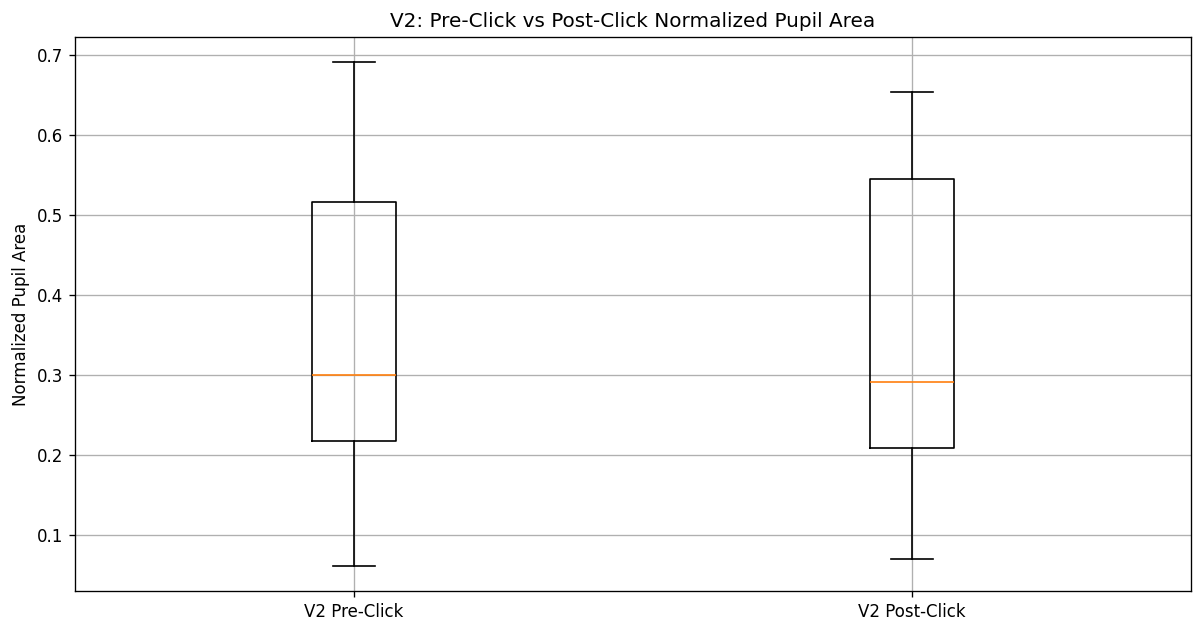

### V4 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 24.000000                  24.000000
mean                   0.299520                   0.335010
std                    0.124499                   0.126553
min                    0.104786                   0.101053
25%                    0.197195                   0.254673
50%                    0.267025                   0.327479
75%                    0.426729                   0.387220
max                    0.537427                   0.656657


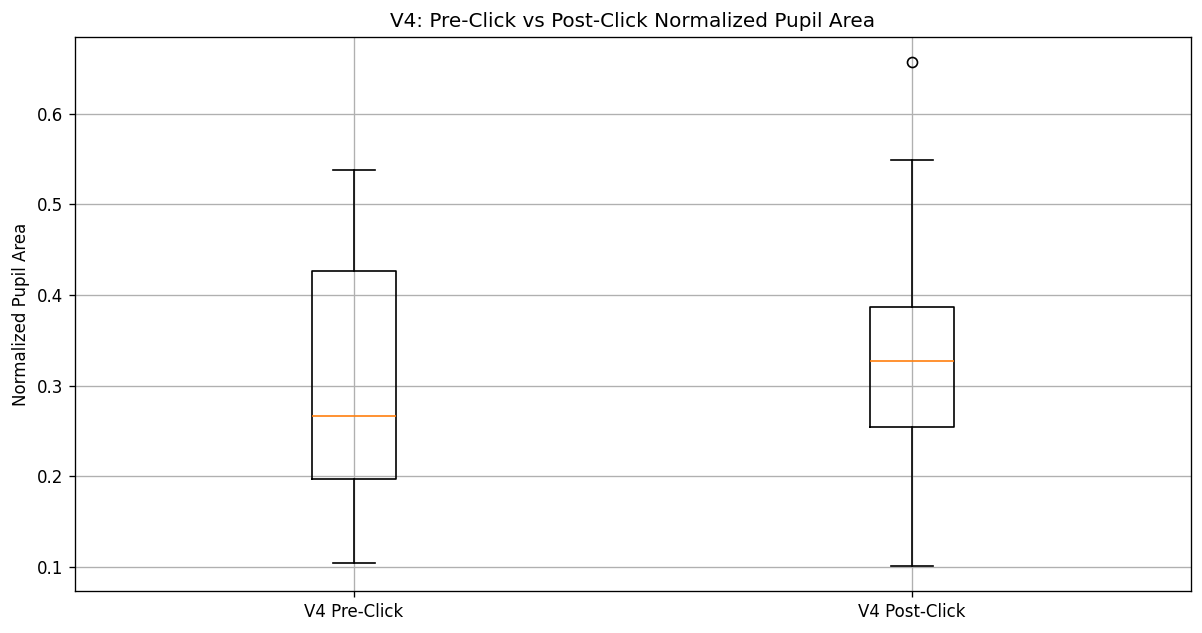

### Post-Click: V2 vs V4 ###
       V2 Post-Click  V4 Post-Click
count      61.000000      24.000000
mean        0.353593       0.335010
std         0.176392       0.126553
min         0.069922       0.101053
25%         0.208844       0.254673
50%         0.291274       0.327479
75%         0.545308       0.387220
max         0.653176       0.656657


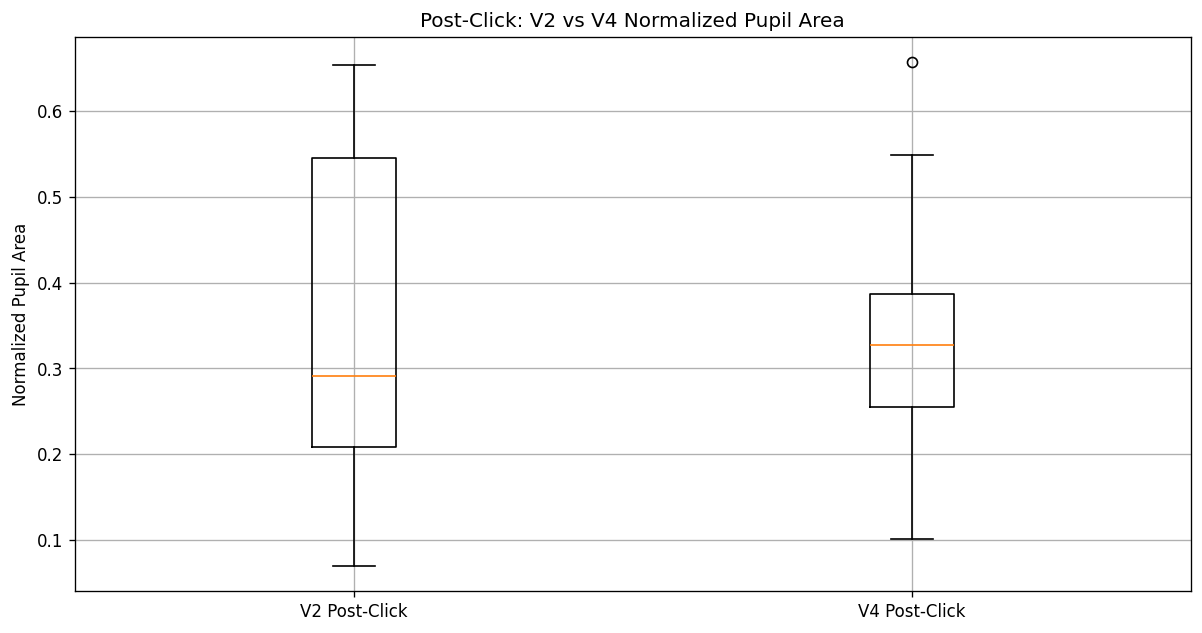

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process user data
def process_user_data(mouse_file, pupil_file):
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Min-Max normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Pre- and post-click analysis
    def calculate_pre_post_pupil_areas(click_data, pupil_data):
        results = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click and post-click windows
            pre_click = pupil_data[(pupil_data['timecode'] >= click_time - 5) & (pupil_data['timecode'] < click_time)]
            post_click = pupil_data[(pupil_data['timecode'] >= click_time + 2) & (pupil_data['timecode'] < click_time + 5)]

            results.append({
                'Pre-Click Avg Pupil Area': pre_click['normalized-pupil-area'].mean(),
                'Post-Click Avg Pupil Area': post_click['normalized-pupil-area'].mean()
            })
        return pd.DataFrame(results)

    return calculate_pre_post_pupil_areas(click_data[click_data['Is Promotional'] == True], pupil_data)

# Compare V2 and V4
def compare_versions(v2_mouse_files, v2_pupil_files, v4_mouse_files, v4_pupil_files):
    all_v2_results = []
    all_v4_results = []

    # Process V2
    for v2_mouse, v2_pupil in zip(v2_mouse_files, v2_pupil_files):
        v2_results = process_user_data(v2_mouse, v2_pupil)
        all_v2_results.append(v2_results)

    # Process V4
    for v4_mouse, v4_pupil in zip(v4_mouse_files, v4_pupil_files):
        v4_results = process_user_data(v4_mouse, v4_pupil)
        all_v4_results.append(v4_results)

    # Combine results
    combined_v2 = pd.concat(all_v2_results, ignore_index=True)
    combined_v4 = pd.concat(all_v4_results, ignore_index=True)

    return combined_v2, combined_v4

# File lists for V2 and V4
v2_mouse_files = ['anushka2.csv', 'aryaman2.csv', 'jain2.csv', 'priyanshu2.csv', 'rhea2.csv', 'amog2.csv','priyansh2.csv','priyanshu2.csv','sani2.csv','suhani2.csv','surabhi2.csv','tanya2.csv','trusha2.csv','vaish2.csv']
v2_pupil_files = ['anuksha_v2.csv', 'aryamann_v2.csv', 'jain_v2.csv', 'priyanshu_v2.csv', 'rhea_v2.csv', 'amog_v2.csv', 'priyansh_v2.csv', 'priyanshu_v2.csv', 'sanidhya_v2.csv', 'suhani_v2.csv','surabhi_v2.csv', 'tanya_v2.csv', 'trusha_v2.csv', 'vaish_v2.csv']

v4_mouse_files = ['anushka4.csv', 'aryaman4.csv', 'jain4.csv', 'priyanshu4.csv', 'rhea4.csv', 'amog4.csv','priyansh4.csv','priyanshu4.csv','sani4.csv','suhani4.csv','surabhi4.csv','tanya4.csv','trusha4.csv','vaish4.csv']
v4_pupil_files = ['anuksha_v4.csv', 'aryamann_v4.csv', 'jain_v4.csv', 'priyanshu_v4.csv', 'rhea_v4.csv',  'amog_v4.csv', 'priyansh_v4.csv', 'priyanshu_v4.csv', 'sanidhya_v4.csv', 'suhani_v4.csv','surabhi_v4.csv', 'tanya_v4.csv', 'trusha_v4.csv', 'vaish_v4.csv']

# Compare V2 and V4
combined_v2, combined_v4 = compare_versions(v2_mouse_files, v2_pupil_files, v4_mouse_files, v4_pupil_files)

# 1. Compare Pre-Click vs Post-Click in V2
print("### V2 Pre-Click vs Post-Click ###")
print(combined_v2.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v2['Pre-Click Avg Pupil Area'].dropna(),
             combined_v2['Post-Click Avg Pupil Area'].dropna()],
            labels=['V2 Pre-Click', 'V2 Post-Click'])
plt.title("V2: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 2. Compare Pre-Click vs Post-Click in V4
print("### V4 Pre-Click vs Post-Click ###")
print(combined_v4.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v4['Pre-Click Avg Pupil Area'].dropna(),
             combined_v4['Post-Click Avg Pupil Area'].dropna()],
            labels=['V4 Pre-Click', 'V4 Post-Click'])
plt.title("V4: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 3. Compare Post-Click in V2 vs Post-Click in V4
print("### Post-Click: V2 vs V4 ###")
post_click_v2 = combined_v2['Post-Click Avg Pupil Area'].dropna()
post_click_v4 = combined_v4['Post-Click Avg Pupil Area'].dropna()

comparison_df = pd.DataFrame({'V2 Post-Click': post_click_v2, 'V4 Post-Click': post_click_v4})
print(comparison_df.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([post_click_v2, post_click_v4], labels=['V2 Post-Click', 'V4 Post-Click'])
plt.title("Post-Click: V2 vs V4 Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()


### V2 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 59.000000                  59.000000
mean                   0.363620                   0.361901
std                    0.170235                   0.173706
min                    0.060802                   0.069922
25%                    0.228399                   0.207750
50%                    0.307992                   0.292199
75%                    0.532855                   0.548483
max                    0.690884                   0.653176


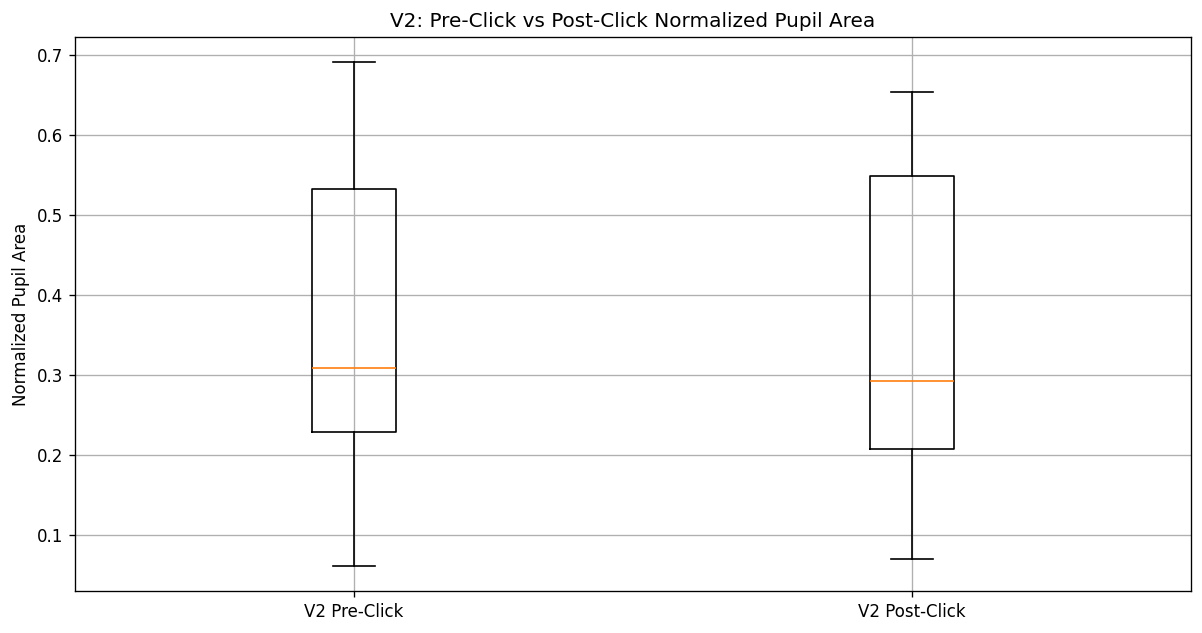

### V3 Pre-Click vs Post-Click ###
       Pre-Click Avg Pupil Area  Post-Click Avg Pupil Area
count                 48.000000                  48.000000
mean                   0.418708                   0.453376
std                    0.180789                   0.184906
min                    0.131059                   0.139064
25%                    0.255105                   0.288670
50%                    0.411714                   0.495478
75%                    0.592047                   0.593026
max                    0.701950                   0.742518


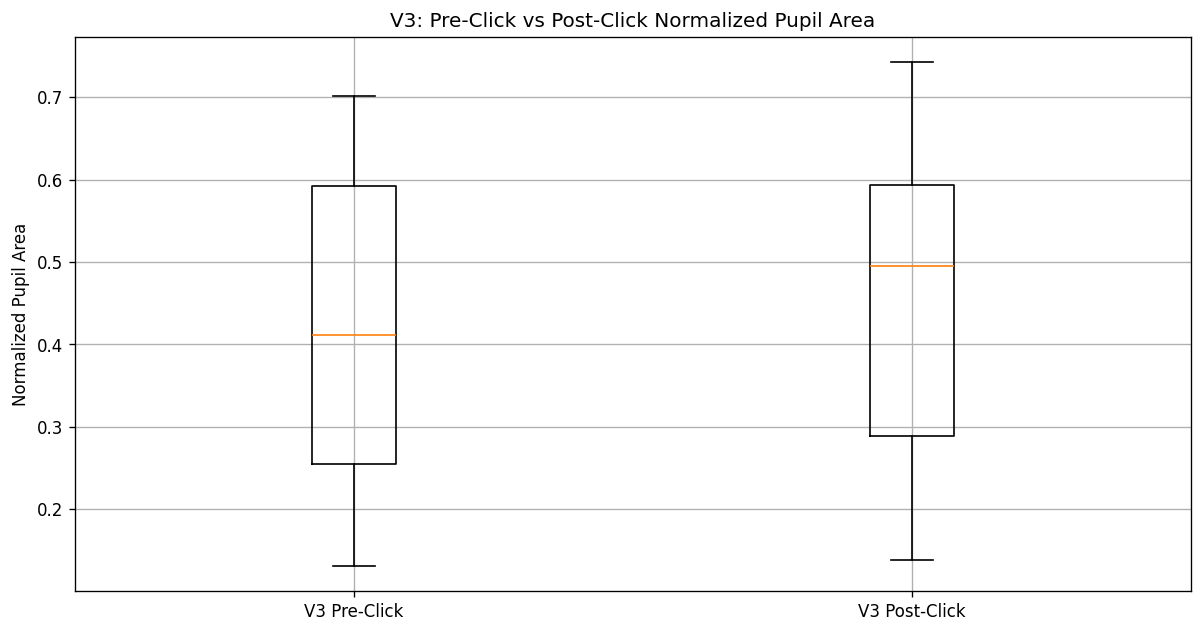

### Post-Click: V2 vs V3 ###
       V2 Post-Click  V3 Post-Click
count      59.000000      48.000000
mean        0.361901       0.453376
std         0.173706       0.184906
min         0.069922       0.139064
25%         0.207750       0.288670
50%         0.292199       0.495478
75%         0.548483       0.593026
max         0.653176       0.742518


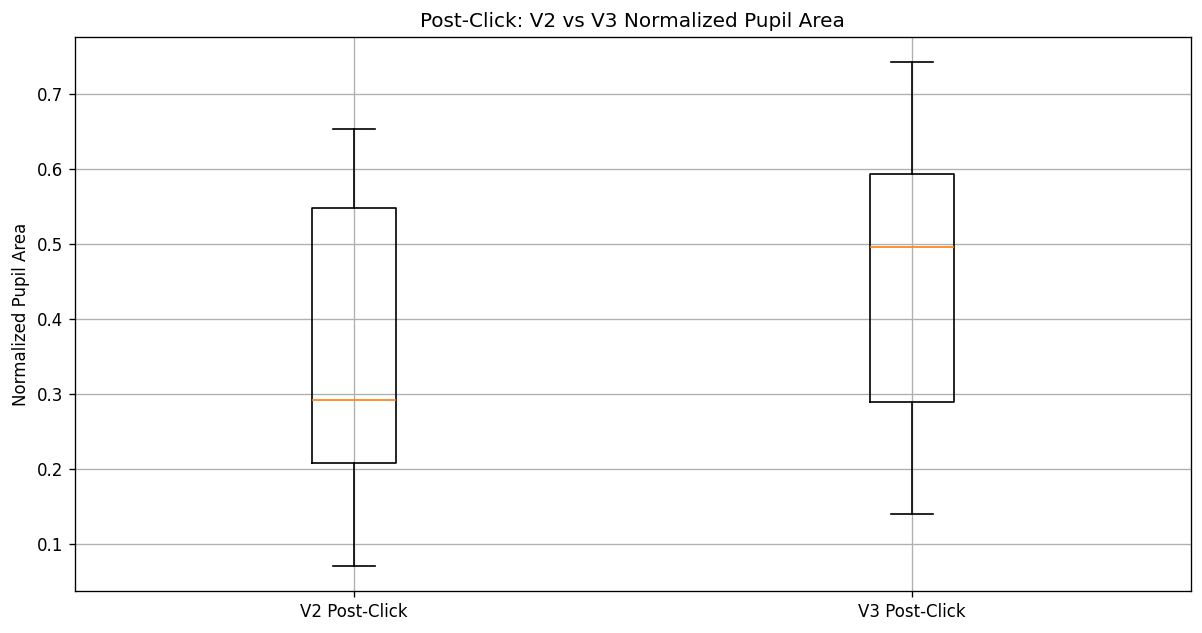

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to process user data
def process_user_data(mouse_file, pupil_file):
    click_data = pd.read_csv(mouse_file)
    pupil_data = pd.read_csv(pupil_file)

    # Convert timestamps
    click_data['Timecode (seconds)'] = pd.to_numeric(click_data['Timecode (seconds)'], errors='coerce')
    pupil_data['timecode'] = pd.to_numeric(pupil_data['timecode'], errors='coerce')

    # Replace zeros with mean of non-zero values
    non_zero_mean = pupil_data.loc[pupil_data['pupil-area'] > 0, 'pupil-area'].mean()
    pupil_data['pupil-area'] = pupil_data['pupil-area'].replace(0, non_zero_mean)

    # Min-Max normalization
    min_val = pupil_data['pupil-area'].min()
    max_val = pupil_data['pupil-area'].max()
    pupil_data['normalized-pupil-area'] = (pupil_data['pupil-area'] - min_val) / (max_val - min_val)

    # Pre- and post-click analysis
    def calculate_pre_post_pupil_areas(click_data, pupil_data):
        results = []
        for _, click_row in click_data.iterrows():
            click_time = click_row['Timecode (seconds)']

            # Pre-click and post-click windows
            pre_click = pupil_data[(pupil_data['timecode'] >= click_time - 5) & (pupil_data['timecode'] < click_time)]
            post_click = pupil_data[(pupil_data['timecode'] >= click_time + 2) & (pupil_data['timecode'] < click_time + 5)]

            results.append({
                'Pre-Click Avg Pupil Area': pre_click['normalized-pupil-area'].mean(),
                'Post-Click Avg Pupil Area': post_click['normalized-pupil-area'].mean()
            })
        return pd.DataFrame(results)

    return calculate_pre_post_pupil_areas(click_data[click_data['Is Promotional'] == True], pupil_data)

# Compare V2 and V3
def compare_versions(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files):
    all_v2_results = []
    all_v3_results = []

    # Process V2
    for v2_mouse, v2_pupil in zip(v2_mouse_files, v2_pupil_files):
        v2_results = process_user_data(v2_mouse, v2_pupil)
        all_v2_results.append(v2_results)

    # Process V3
    for v3_mouse, v3_pupil in zip(v3_mouse_files, v3_pupil_files):
        v3_results = process_user_data(v3_mouse, v3_pupil)
        all_v3_results.append(v3_results)

    # Combine results
    combined_v2 = pd.concat(all_v2_results, ignore_index=True)
    combined_v3 = pd.concat(all_v3_results, ignore_index=True)

    return combined_v2, combined_v3

# File lists for V2 and V3
v2_mouse_files = ['anushka2.csv', 'aryaman2.csv', 'jain2.csv', 'priyanshu2.csv', 'rhea2.csv', 'amog2.csv','priyansh2.csv','priyanshu2.csv','sani2.csv','suhani2.csv','surabhi2.csv','tanya2.csv','trusha2.csv','vaish2.csv']
v2_pupil_files = ['anuksha_v2.csv', 'aryamann_v2.csv', 'jain_v2.csv', 'priyanshu_v2.csv', 'rhea_v2.csv', 'amog_v2.csv', 'priyansh_v2.csv', 'priyanshu_v2.csv', 'sanidhya_v2.csv', 'suhani_v2.csv','surabhi_v2.csv', 'tanya_v2.csv', 'trusha_v2.csv', 'vaish_v2.csv']

v3_mouse_files = ['anushka3.csv', 'aryaman3.csv', 'jain3.csv', 'priyanshu3.csv', 'rhea3.csv', 'amog3.csv','priyansh3.csv','priyanshu3.csv','sani3.csv','suhani3.csv','surabhi3.csv','tanya3.csv','trusha3.csv','vaish3.csv']
v3_pupil_files = ['anuksha_v3.csv', 'aryamann_v3.csv', 'jain_v3.csv', 'priyanshu_v3.csv', 'rhea_v3.csv',  'amog_v3.csv', 'priyansh_v3.csv', 'priyanshu_v3.csv', 'sanidhya_v3.csv', 'suhani_v3.csv','surabhi_v3.csv', 'tanya_v3.csv', 'trusha_v3.csv', 'vaish_v3.csv']

# Compare V2 and V3
combined_v2, combined_v3 = compare_versions(v2_mouse_files, v2_pupil_files, v3_mouse_files, v3_pupil_files)

# 1. Compare Pre-Click vs Post-Click in V2
print("### V2 Pre-Click vs Post-Click ###")
print(combined_v2.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v2['Pre-Click Avg Pupil Area'].dropna(),
             combined_v2['Post-Click Avg Pupil Area'].dropna()],
            labels=['V2 Pre-Click', 'V2 Post-Click'])
plt.title("V2: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 2. Compare Pre-Click vs Post-Click in V3
print("### V3 Pre-Click vs Post-Click ###")
print(combined_v3.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([combined_v3['Pre-Click Avg Pupil Area'].dropna(),
             combined_v3['Post-Click Avg Pupil Area'].dropna()],
            labels=['V3 Pre-Click', 'V3 Post-Click'])
plt.title("V3: Pre-Click vs Post-Click Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()

# 3. Compare Post-Click in V2 vs Post-Click in V3
print("### Post-Click: V2 vs V3 ###")
post_click_v2 = combined_v2['Post-Click Avg Pupil Area'].dropna()
post_click_v3 = combined_v3['Post-Click Avg Pupil Area'].dropna()

comparison_df = pd.DataFrame({'V2 Post-Click': post_click_v2, 'V3 Post-Click': post_click_v3})
print(comparison_df.describe())

plt.figure(figsize=(12, 6), dpi=120)
plt.boxplot([post_click_v2, post_click_v3], labels=['V2 Post-Click', 'V3 Post-Click'])
plt.title("Post-Click: V2 vs V3 Normalized Pupil Area")
plt.ylabel("Normalized Pupil Area")
plt.grid(True)
plt.show()
